<br>
<br>

Introduction
==========

Put some introduction here. 

<br>
<br>

[//]: <> (This is also a comment.)

In [1]:
# import standard modules
import os
import sys
import string
import subprocess
import time
import math

In [2]:
# Most likely, you have to fix the path. Note that pcraster must always be the first.
os.environ["PATH"] = "/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin"
print(os.environ["PATH"])

# test using aguila
!aguila

# TODO: Investigate why we need this? This should not happen.

/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-sutan101'
libGL error: unable to load driver: swrast_dri.so
libGL error: failed to load driver: swrast
qt.qpa.xcb: QXcbConnection: XCB error: 145 (Unknown), sequence: 175, resource id: 0, major code: 139 (Unknown), minor code: 20


In [3]:
# import required modules/packages (which may require installations)

import numpy as np
import pandas as pd
import geopandas as gpd

from scipy.spatial import Delaunay

from shapely.geometry import MultiLineString
from shapely.ops import cascaded_union, polygonize

import matplotlib
# %matplotlib notebook
# TODO: Note that pcr.plot() still does not support interactive zoom-ing.

from collections import OrderedDict

import pcraster as pcr

In [4]:
# check the path and test aguila
# print(os.environ["PATH"])
# test aguila 
# pcr.aguila()

In [5]:
!aguila

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-sutan101'
libGL error: unable to load driver: swrast_dri.so
libGL error: failed to load driver: swrast
qt.qpa.xcb: QXcbConnection: XCB error: 145 (Unknown), sequence: 175, resource id: 0, major code: 139 (Unknown), minor code: 20


In [6]:
# import sub-modules

import mapIO
import pcrRecipes
import measures_py3 as msr


<br>
<br>

Please define output and input folders.

In [7]:
# - for test on cartesius
# output_dir  = "/scratch/depfg/sutan101/tmp_menno/out/"
# input_dir   = "/scratch/depfg/hydrowld/river_scape/source/from_menno/riverscape/input/"
# scratch_dir = "/scratch/depfg/sutan101/tmp_menno/tmp/"

# - for test on fleet
output_dir  = "/scratch/sutan101/tmp_menno_test/out/"
input_dir   = "/home/sutan101/data/river_scape/source/from_menno/riverscape/input/"
scratch_dir = output_dir + "/tmp/"


<br>

Start processing/calculation ....
========================

<br>


In [8]:
# starting time of this script
start_time = time.time()

In [9]:
# make scratch directory and go to this folder
pcrRecipes.make_dir(scratch_dir)
os.chdir(scratch_dir)

In [10]:
# set global option for pcraster such that length of cells is computed in true length of cells
pcr.setglobaloption('unittrue')
# TODO: Check with Menno why we need this?

In [11]:
# set the pcraster clone map
current_dir = os.path.join(input_dir, 'reference_maps')
pcr.setclone(os.path.join(current_dir, 'clone.map'))

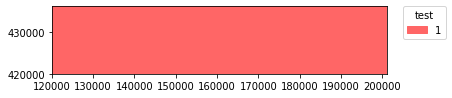

In [12]:
# check and plot the clone map
test = pcr.readmap(os.path.join(current_dir, 'clone.map'))
pcr.plot(test) 

In [13]:
# change to the 'current_dir' (input data) for reading/importing input data
os.chdir(current_dir)
!pwd
#TODO: Check why do we need this? It seems that os.path.join does not work?

/home/sutan101/data/river_scape/source/from_menno/riverscape/input/reference_maps


In [14]:
# reading current/existing river embankment properties for main dikes, minor embankments and groynes 
# - for each, this will return location, length, volume, and height - #TODO: unit is needed here. 
main_dike = msr.read_dike_maps(current_dir, 'main_dike')
minemb    = msr.read_dike_maps(current_dir, 'minemb')
groynes   = msr.read_dike_maps(current_dir, 'groyne')

In [15]:
# reading Hydrodynamics (delft3d-fm) attributes 
# - chezy, nikuradse, specific discharge, velocity, water depth, water level, etc
hydro = msr.read_hydro_maps(current_dir)
# - hydodynamic mesh
mesh = msr.read_mesh_maps(current_dir)

# TODO: Shall we define plots for hydro and mesh attributes

In [16]:
# reading RiverScape attributes
# - axis: location, radius, turning_direction, rkm, rkm_point, rkm_line, rkm_full
axis = msr.read_axis_maps(current_dir)
# - geometry: clone, dem, distance to main dike, distance to groyne, distance to main channel, 
#            floodplain widths, contiguous narrow floodplain, contiguous wide floodplain
geom = msr.read_geom_maps(current_dir)
# reading land use land cover attribute
lulc = msr.read_lulc_maps(current_dir)

# TODO: Shall we define their plots?

In [17]:
# go to the scratch directory so that all temporary files (e.g. made during aguila) would be stored there 
os.chdir(scratch_dir)

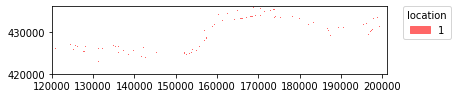

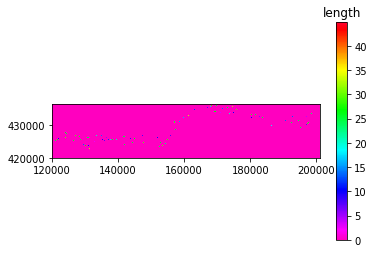

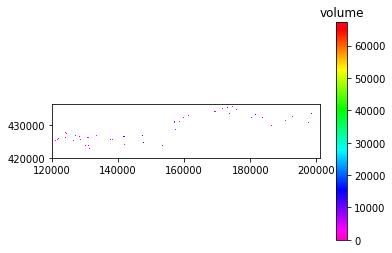

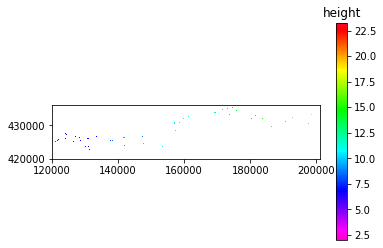

In [18]:
# plot main embankments
main_dike.plot()

In [19]:
# close all aguila processes
!killall aguila

aguila: no process found


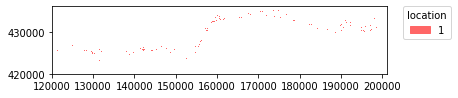

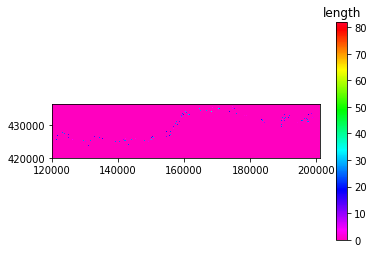

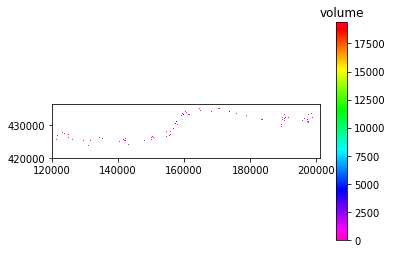

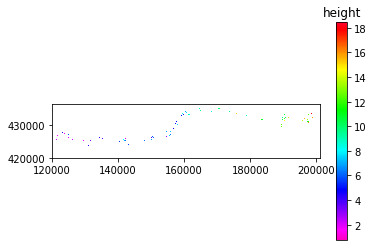

In [20]:
# plot minor embankment
minemb.plot()

In [21]:
# close all aguila processes
!killall aguila

aguila: no process found


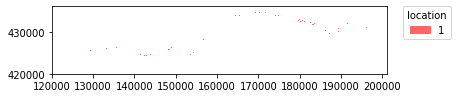

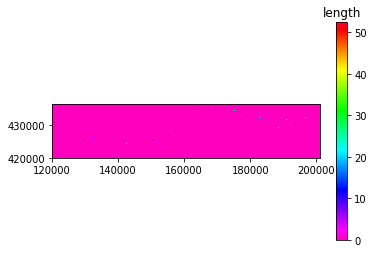

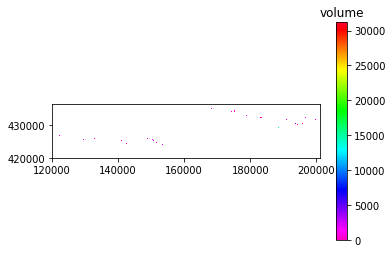

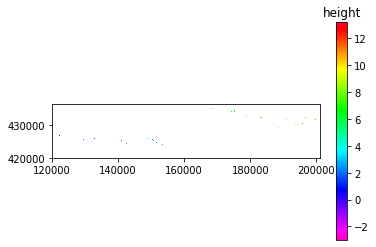

In [22]:
# plot groynes
groynes.plot()

In [23]:
# close all aguila processes
!killall aguila

aguila: no process found


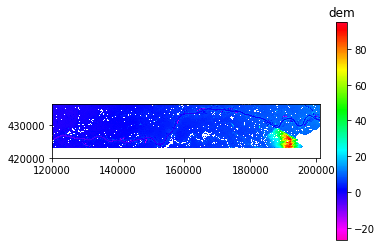

In [24]:
# plot the digital elevation model
pcr.aguila(geom.dem)
dem = geom.dem ; pcr.plot(dem)

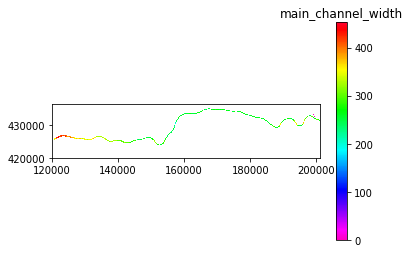

In [25]:
# plot river main channel width
pcr.aguila(geom.main_channel_width)
main_channel_width = geom.main_channel_width ; pcr.plot(main_channel_width)

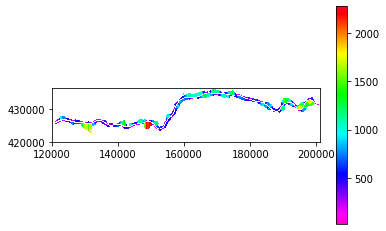

In [26]:
pcr.aguila(geom.main_channel_width)
pcr.plot(geom.flpl_width)

In [27]:
# close all aguila processes
!killall aguila

aguila: no process found


In [28]:
# The River Wall is initiated based on the aformentioned given attributes.
waal = msr.River('Waal', axis, main_dike, minemb, groynes, hydro, 
                         mesh, lulc, geom)

In [29]:
# Initiate the Measures for the River.
waal_msr = msr.RiverMeasures(waal)

In [30]:
# Default setting/configuration to the Measures.
settings = OrderedDict([
                    ('smoothing_percentage', 100),
                    ('smoothing_ecotope', 'UG-2'),
                    ('smoothing_trachytope', 1201),
                    
                    ('lowering_percentage', 100),
                    ('lowering_ecotope', 'UG-2'),
                    ('lowering_trachytope', 1201),
                    ('lowering_height', 'water_level_50d'),
                    
                    ('channel_width', 75),
                    ('channel_depth', 2.5),
                    ('channel_slope', 1./3.),
                    ('channel_ecotope', 'RnM'),
                    ('channel_trachytope', 105),
                    
                    ('relocation_alpha', 10000),
                    ('relocation_depth', 'AHN'),
                    ('relocation_ecotope', 'HG-2'),
                    ('relocation_trachytope', 1201),
                    
                    ('groyne_ref_level', 'wl_exc150d'),
                    ('minemb_ref_level', 'wl_exc50d'),
                    ('main_dike_dh', 0.50),
                    ])

In [31]:
# TODO: Make interactive input for the settings. 

In [32]:
# Put your setting/configuration to the Measures. 
waal_msr.settings = settings

In [33]:
# Default mask and ID
mask = pcr.boolean(1)
ID = 'everywhere'

# TODO: Ask again Menno what the differences between "mask" and "ID"?

In [34]:
# TODO: Make interactive input for selecting IDs. 

In [35]:
# an example to select limited mask regions

# large_sections = pcr.ifthen(pcr.areaarea(waal.geom.flpl_wide) > 1e6, waal.geom.flpl_wide)
# mask = pcr.boolean(flpl_section)

# flpl_section = pcr.ifthen(large_sections == 1, pcr.nominal(1))
# mask = pcr.boolean(flpl_section)

# pcr.aguila(mask)
# pcr.plot(mask)

In [36]:
# floodplain lowering measure
ID = "edwin"
lowering_msr = waal_msr.lowering_measure(settings, mask=mask, ID=ID)

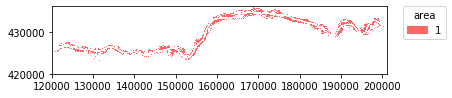

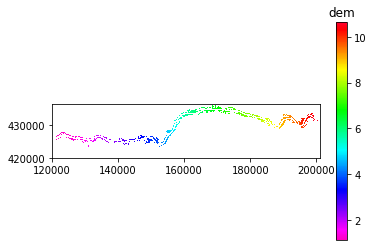

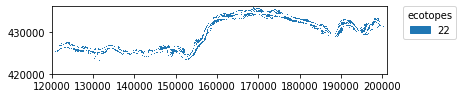

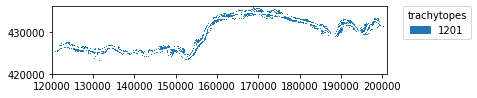

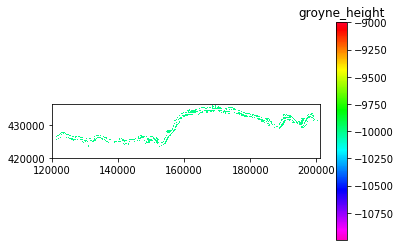

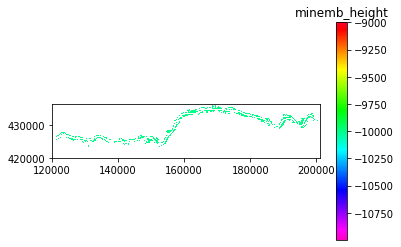

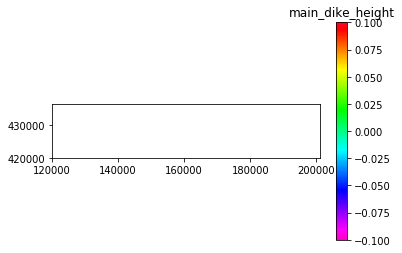

In [37]:
# plot/explore floodplain lowering measure
lowering_msr.plot()

In [38]:
# close all aguila processes 
!killall aguila

aguila: no process found


In [39]:
# groyne lowering measure
groyne_low_msr = waal_msr.groyne_lowering_msr(settings, mask=mask, ID=ID)

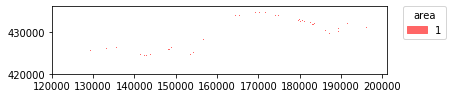

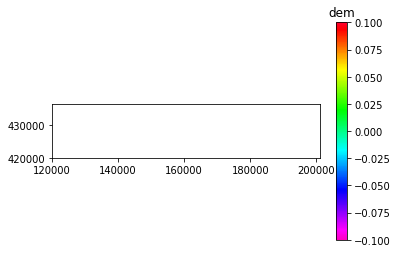

/home/sutan101/opt/anaconda2/envs/rs-env/lib/python3.6/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/sutan101/opt/anaconda2/envs/rs-env/lib/python3.6/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/sutan101/opt/anaconda2/envs/rs-env/lib/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/sutan101/opt/anaconda2/envs/rs-env/lib/python3.6/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/sutan101/opt/anaconda2/envs/rs-env/lib/python3.6/site-packages/matplotlib/colors.py:933: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/sutan101/opt/anaconda2/envs/rs-env/lib/python3.6/site-packages/numpy/ma/

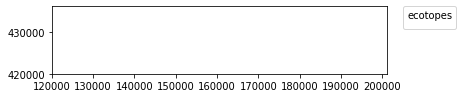

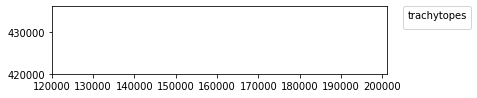

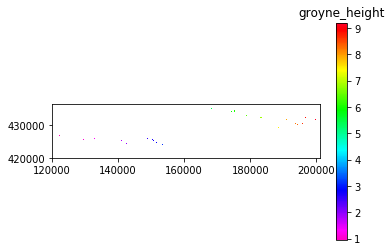

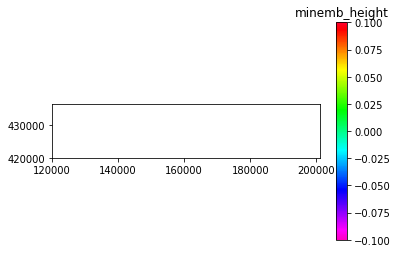

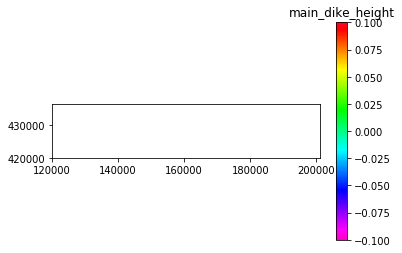

In [40]:
# plot/explore groyne lowering measure
groyne_low_msr.plot()

In [41]:
# close all aguila processes 
!killall aguila

aguila: no process found


In [42]:
# measure by minor embankment lowering
minemb_low_msr = waal_msr.minemb_lowering_msr(settings, mask=mask, ID=ID)

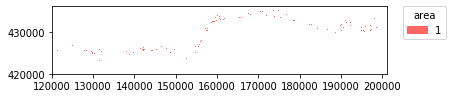

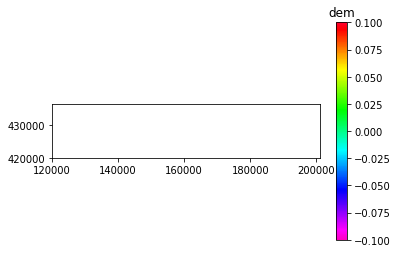

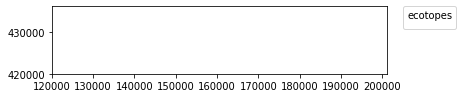

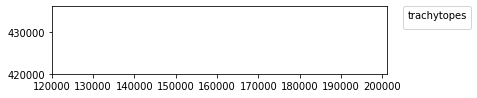

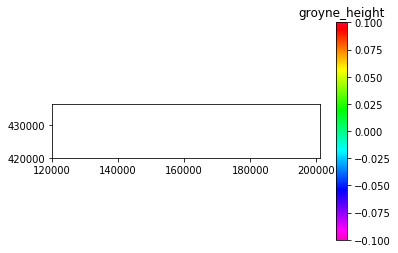

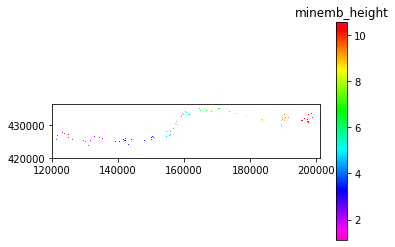

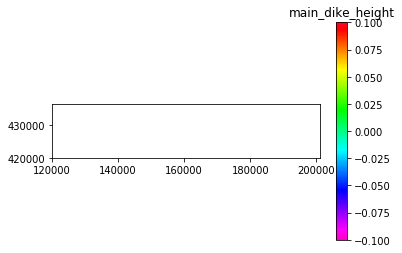

In [43]:
# plot/explore minor embankment lowering
minemb_low_msr.plot()

In [44]:
# close all aguila processes 
!killall aguila

aguila: no process found


In [45]:
# measure by main dike raising
main_dike_raise_msr = waal_msr.main_dike_raising_msr(settings, mask=mask, ID=ID)

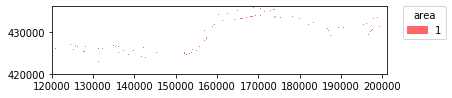

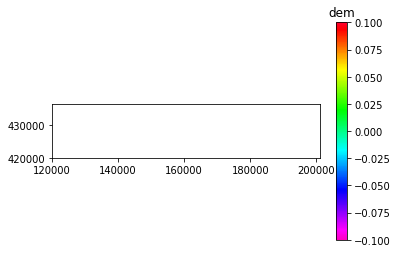

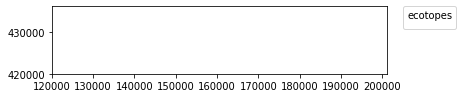

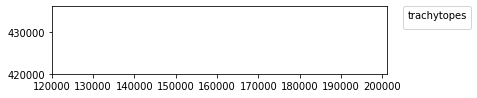

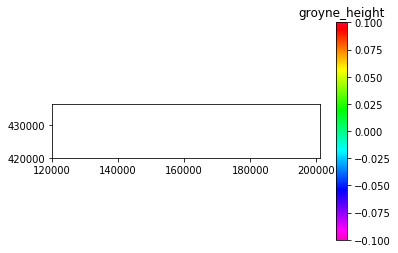

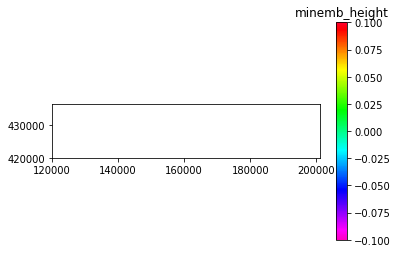

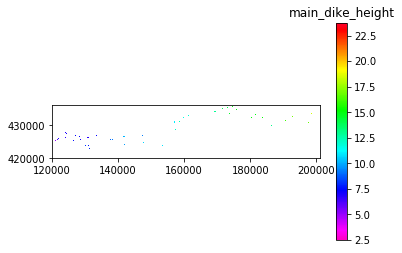

In [46]:
# plot/explore main dike raising measure
main_dike_raise_msr.plot()

In [47]:
# close all aguila processes 
!killall aguila

aguila: no process found


In [51]:
# measure by side channel constrcution
ID = 'everywhere'
# - this includes looping over flood plain IDs
chan_msr = waal_msr.side_channel_measure(settings, mask=mask, ID=ID)

[1, 2, 3, 8, 10, 13, 14, 18, 20, 22, 23, 27, 30, 39, 40, 43, 49, 54, 56]
1
2
3
8
10
13
14
18
20
22
23
27
30
39
40
43
49
54
56


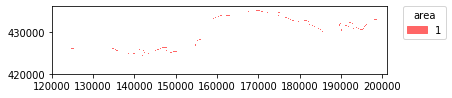

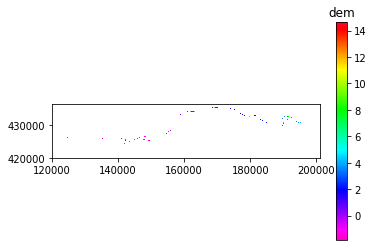

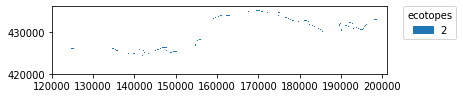

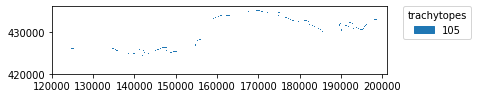

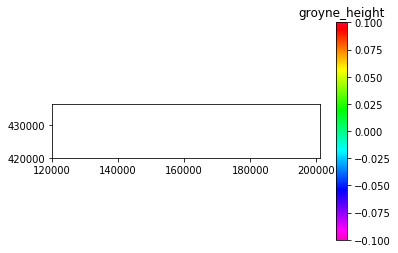

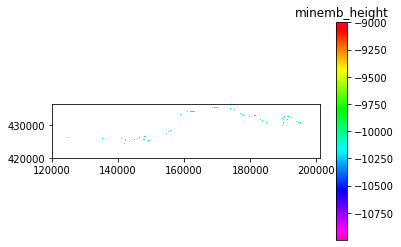

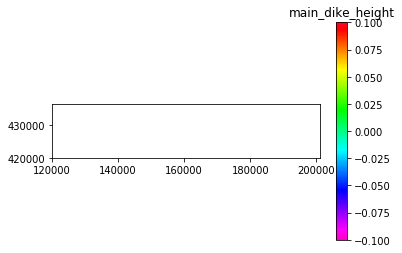

In [52]:
# plot/explore side channel measure
chan_msr.plot()

In [53]:
# measure by roughness smoothing
smooth_msr = waal_msr.smoothing_measure(settings, mask=mask, ID=ID)

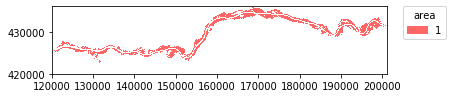

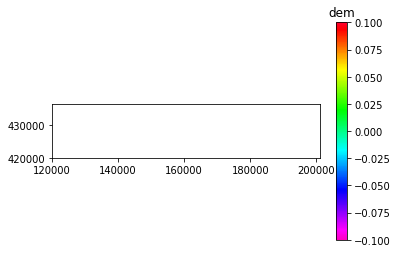

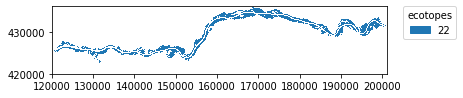

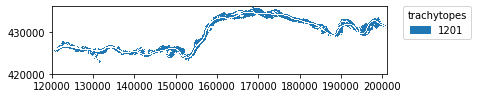

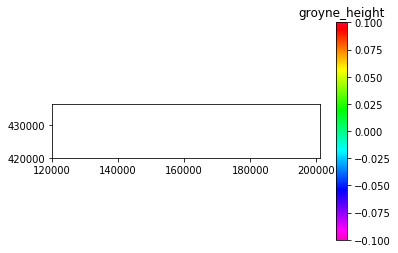

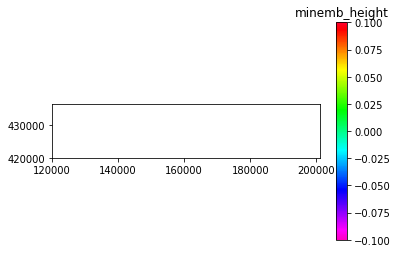

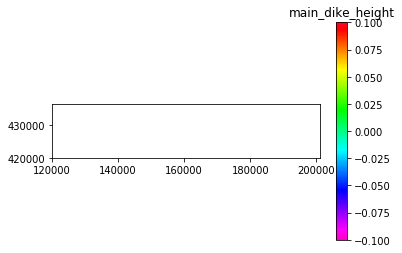

In [54]:
# plot/explore measure by roughness smoothing
smooth_msr.plot()

In [55]:
# close all aguila processes 
!killall aguila

aguila: no process found


Saving measures to the disk
========================

In [56]:
# list of measures
msr_list = [groyne_low_msr, minemb_low_msr,
            main_dike_raise_msr, lowering_msr, chan_msr, smooth_msr]
# - preparing the directory
msr_root_dir = os.path.join(output_dir, 'measures_ensemble03/maps')
pcrRecipes.make_dir(msr_root_dir)
for measure in msr_list:
    msr.write_measure(measure, msr_root_dir)

/scratch/sutan101/tmp_menno_test/out/measures_ensemble03/maps/groynelowering_everywhere
/scratch/sutan101/tmp_menno_test/out/measures_ensemble03/maps/minemblowering_everywhere
/scratch/sutan101/tmp_menno_test/out/measures_ensemble03/maps/dikeraising_everywhere
/scratch/sutan101/tmp_menno_test/out/measures_ensemble03/maps/lowering_everywhere
/scratch/sutan101/tmp_menno_test/out/measures_ensemble03/maps/sidechannel_everywhere
/scratch/sutan101/tmp_menno_test/out/measures_ensemble03/maps/smoothing_everywhere
